In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Latest Date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,
       func.avg(Measurement.prcp)]
prcp_last_year = session.query(*sel).\
    filter(Measurement.date > query_date).\
    group_by(Measurement.date).all()

prcp_last_year
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_last_year, columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_values(by=['date'])
prcp_df.head()

Query Date:  2016-08-23


,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


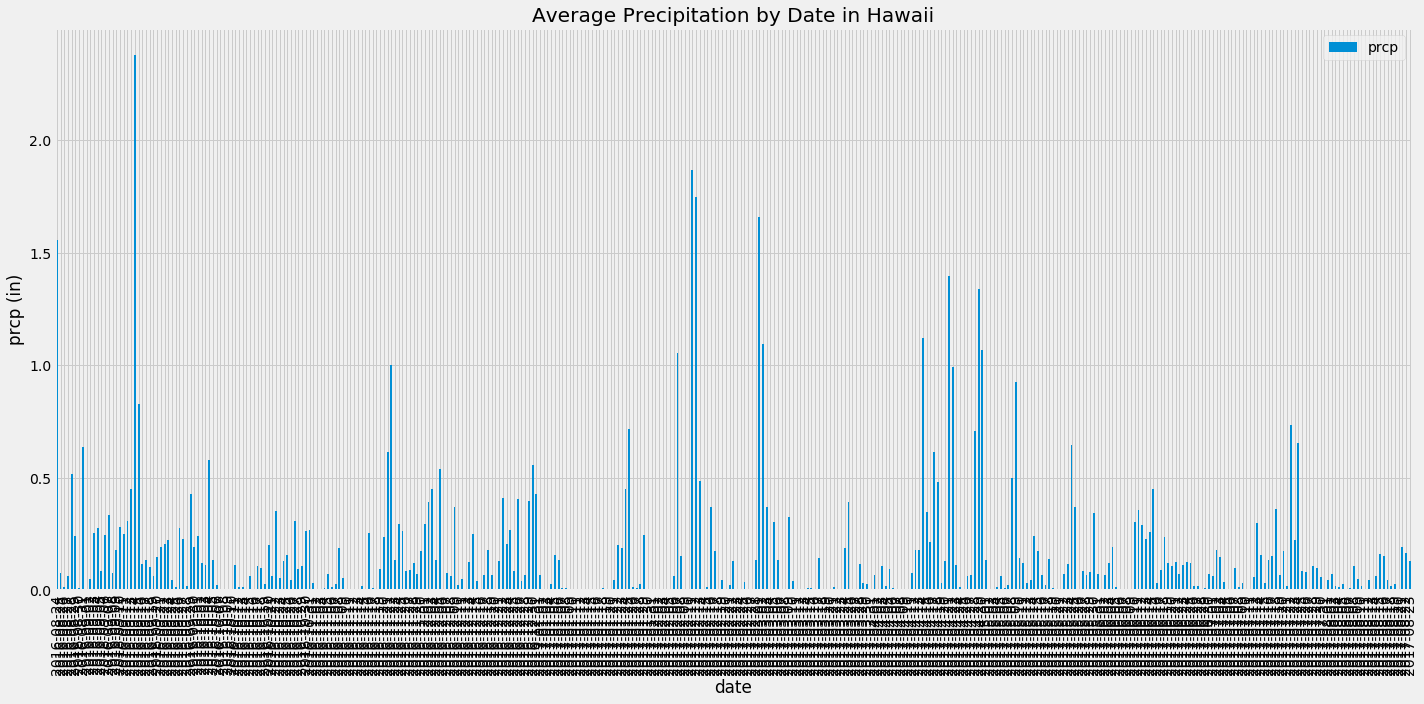

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='bar', figsize=(20,10))

#plt.xticks(x,"")
plt.title("Average Precipitation by Date in Hawaii")
plt.ylabel("prcp (in)")
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.prcp.describe()

count    365.000000
mean       0.169987
std        0.295722
min        0.000000
25%        0.008571
50%        0.070000
75%        0.191667
max        2.380000
Name: prcp, dtype: float64

![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).group_by(Station.station).count()
print("Number of Stations:", stations)

Number of Stations: 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,
      func.count(Measurement.tobs)]
station_counts = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#lowest temp recorded at station USC00519281
session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').all()

min_temp = session.query(func.min(Measurement.tobs)).all()
print("Lowest Temp:", min_temp)

#Highest temp recorded at station USC00519281
max_temp = session.query(func.max(Measurement.tobs)).all()
print("Highest Temp:", max_temp)

#Avg temp recorded at station USC00519281
avg_temp = session.query(func.avg(Measurement.tobs)).all()
print("Average Temp:", avg_temp)

Lowest Temp: [(53.0,)]
Highest Temp: [(87.0,)]
Average Temp: [(73.09795396419437,)]


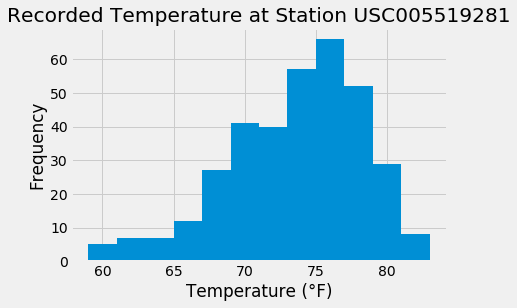

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.station, 
       Measurement.date,
       Measurement.tobs]
temp_last_year = session.query(*sel).\
    filter(Measurement.date > query_date).\
    filter(Measurement.station == 'USC00519281').all()

temp_last_year

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.DataFrame(temp_last_year, columns=['date', 'station', 'tobs'])
temp_df.set_index('date', inplace=True)
temp_df.head()

#create histogram
temperatures = temp_df['tobs']
plt.hist(temperatures, bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title("Recorded Temperature at Station USC005519281")
plt.show()

![precipitation](Images/station-histogram.png)

In [18]:
#Optional Temperature Analysis I:
#Identify avg temp in June at all stations across all available years
sel = [func.avg(Measurement.tobs)]
june_averages = session.query(*sel).\
    filter(func.strftime("%m", Measurement.date) == "06").all()
    #group_by(Measurement.station).\
    #order_by(Measurement.date).all()
print("June Average Temp:", june_averages)

#Identify avg temp in December at all stations across all available years
sel = [func.avg(Measurement.tobs)]
dec_averages = session.query(*sel).\
    filter(func.strftime("%m", Measurement.date) == "12").all()
    #group_by(Measurement.station).\
    #order_by(Measurement.date).all()
print("December Average Temp:", dec_averages)

#Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?
stats.ttest_ind(june_averages, dec_averages, equal_var=False)

June Average Temp: [(74.94411764705882,)]
December Average Temp: [(71.04152933421226,)]


C:\Users\Nytes\Anaconda3\envs\PythonData\lib\site-packages\numpy\core\fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\Nytes\Anaconda3\envs\PythonData\lib\site-packages\numpy\core\_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\Nytes\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Nytes\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Nytes\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Ttest_indResult(statistic=array([nan]), pvalue=array([nan]))

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#start date of trip
start_date = '2017-12-01'
start_date_format = dt.datetime.strptime(start_date, "%Y-%m-%d")
query_start_date = dt.datetime.date(start_date_format) - dt.timedelta(days=365)

#end date of trip
end_date = '2017-12-10'
end_date_format = dt.datetime.strptime(end_date, "%Y-%m-%d")
query_end_date = dt.datetime.date(end_date_format) - dt.timedelta(days=365)

print(calc_temps(query_start_date, query_end_date))


[(67.0, 71.29230769230769, 77.0)]


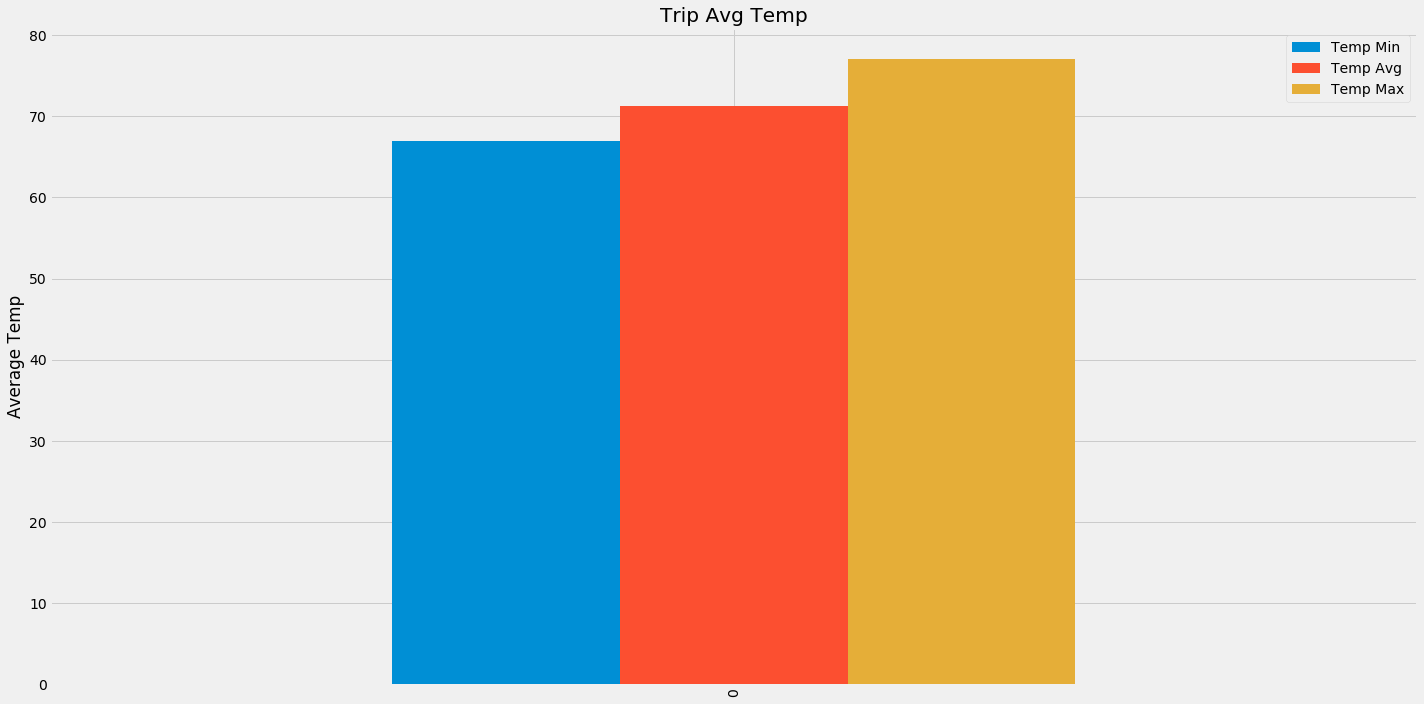

In [34]:
# Plot the results from your previous query as a bar chart.
vacation_temps = (calc_temps(query_start_date, query_end_date))
vacation_temps_df = pd.DataFrame(vacation_temps, columns = ['Temp Min', 'Temp Avg', 'Temp Max'])
vacation_temps_df

# Use Pandas Plotting with Matplotlib to plot the data
vacation_temps_df.plot(kind='bar', figsize=(20,10))

#plt.xticks(x,"")
plt.title("Trip Avg Temp")
plt.ylabel("Average Temp")
plt.tight_layout()
plt.show()

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
